Linhas carregadas: 2208


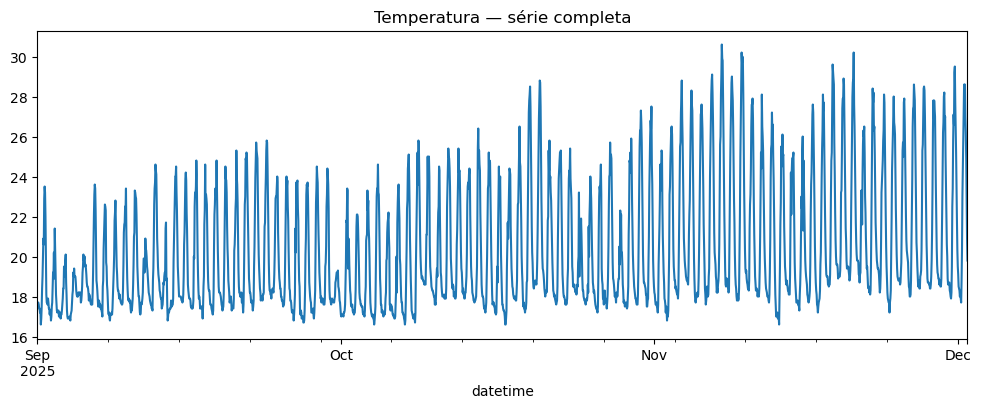

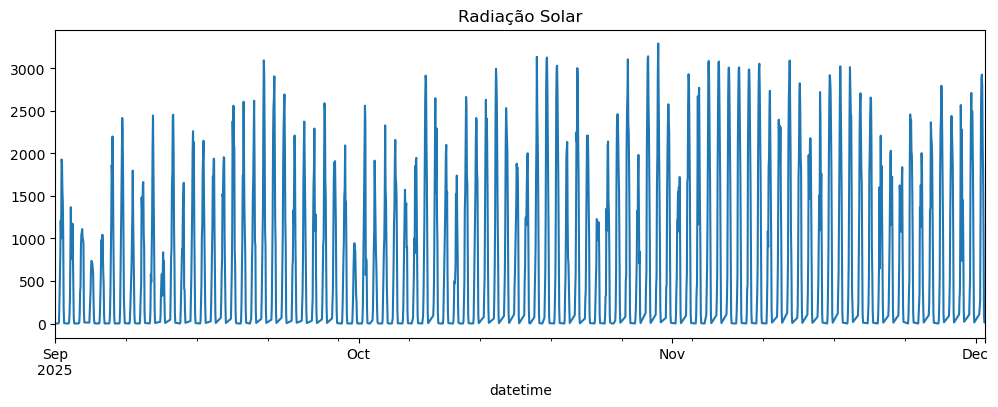

Linhas finais para modelagem: 2183
Treino: (1983, 33)
Teste: (200, 33)
OK — Dataset preparado para modelagem!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_raw = pd.read_csv("data/generatedBy_react-csv.csv", sep=";")
print("Linhas carregadas:", len(df_raw))
df_raw.head()
cols_to_numeric = [
    'Temp. Ins. (C)', 'Umi. Ins. (%)', 'Vel. Vento (m/s)',
    'Radiacao (KJ/m²)', 'Chuva (mm)'
]

for col in cols_to_numeric:
    df_raw[col] = pd.to_numeric(df_raw[col].astype(str).str.replace(",", "."), errors="coerce")

def fix_hora_inmet(h):
    """
    Converte hora INMET (ex: 100 -> 01:00, 1300 -> 13:00, 30 -> 00:30)
    para string HH:MM.
    """
    h = str(h).zfill(4)  
    return h[:2] + ":" + h[2:]

df_raw["Hora_str"] = df_raw["Hora (UTC)"].apply(fix_hora_inmet)
df_raw["datetime"] = pd.to_datetime(
    df_raw["Data"] + " " + df_raw["Hora_str"],
    dayfirst=True
)

df_raw = df_raw.set_index("datetime")

df = df_raw[[
    "Temp. Ins. (C)",
    "Umi. Ins. (%)",
    "Vel. Vento (m/s)",
    "Radiacao (KJ/m²)",
    "Chuva (mm)"
]].copy()

df.columns = ["Temp", "Umi", "Vento", "Rad", "Chuva"]
df = df.resample("H").mean()
df = df.interpolate(method="time")
df = df.ffill().bfill()

df.describe()

df["Temp"].plot(figsize=(12,4), title="Temperatura — série completa")
plt.show()

df["Rad"].plot(figsize=(12,4), title="Radiação Solar")
plt.show()
df_model = df.copy()

lags = [1, 2, 3, 6, 12, 24]

for lag in lags:
    df_model[f"Temp_lag_{lag}"] = df_model["Temp"].shift(lag)
    df_model[f"Umi_lag_{lag}"] = df_model["Umi"].shift(lag)
    df_model[f"Vento_lag_{lag}"] = df_model["Vento"].shift(lag)
    df_model[f"Rad_lag_{lag}"] = df_model["Rad"].shift(lag)
    
df_model["hour"] = df_model.index.hour
df_model["hour_sin"] = np.sin(2*np.pi * df_model["hour"]/24)
df_model["hour_cos"] = np.cos(2*np.pi * df_model["hour"]/24)
df_model["Temp_future_1h"] = df_model["Temp"].shift(-1)
df_model = df_model.dropna()

print("Linhas finais para modelagem:", len(df_model))
df_model.head()

train = df_model.iloc[:-200]
test  = df_model.iloc[-200:]

print("Treino:", train.shape)
print("Teste:", test.shape)

X_train = train.drop(columns=["Temp_future_1h"])
y_train = train["Temp_future_1h"]

X_test = test.drop(columns=["Temp_future_1h"])
y_test = test["Temp_future_1h"]

print("OK — Dataset preparado para modelagem!")
